In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import random
import pandas as pd

from transforms import ToTensorV3

np.random.seed(1234)

In [9]:
from utils import ThousandLandmarksDataset
from torch.utils.data import DataLoader
from utils import CROP_SIZE
from torchvision.transforms import transforms
import torch
from train import init_model
import tqdm
from torch.nn import functional as fnn
import itertools
from utils import restore_landmarks
import albumentations as A
from models import CATALOG

In [3]:
train_path = './data/train/images/'
test_path = './data/test/images/'
train_img_names = [os.path.join(train_path, name) for name in os.listdir(train_path)]
test_img_names = [os.path.join(test_path, name) for name in os.listdir(test_path)]

In [4]:
from torchvision.transforms import transforms

In [5]:
def read_img(img_name):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
train_transforms = A.Compose([
        A.SmallestMaxSize(CROP_SIZE),
        A.CenterCrop(CROP_SIZE, CROP_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV3()
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

## filter data

In [10]:
model = CATALOG['resnet'](971*2)
with open(os.path.join("runs", "resnet_d_432_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [11]:
model.requires_grad_(False)

AvgResNet(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [12]:
train_dataset = ThousandLandmarksDataset("./data/train", train_transforms, split="train")
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=4, pin_memory=True,
                              shuffle=True, drop_last=False)
val_dataset = ThousandLandmarksDataset("./data/train", train_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True,
                            shuffle=False, drop_last=False)

100%|██████████| 64001/64001 [00:00<00:00, 157200.95it/s]


In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
loss_fn = fnn.mse_loss
model.eval()
model.requires_grad_(False)
model.to(device)
loss_list = []
batch_size = 64

In [17]:
for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc="validation..."):
    images = batch["image"].to(device)
    landmarks = batch["landmarks"].to(device)
    landmarks = landmarks.reshape(landmarks.shape[0], -1)# B
    with torch.no_grad():
        pred_landmarks = model(images)
    loss = loss_fn(pred_landmarks, landmarks, reduction='none').to('cpu')
    loss_list.append(
        (
            batch['image_name'], 
            loss.numpy(),
            {
                'landmarks': landmarks.to('cpu').numpy(),
                'predictions': pred_landmarks.to('cpu').numpy(),
            }
        )
    )

validation...: 100%|██████████| 990/990 [03:14<00:00,  5.08it/s]


In [18]:
loss_np = np.concatenate([np.mean(l, axis=-1) for _, l, _ in loss_list])
img_names = list(itertools.chain(*[n for n, _, _ in loss_list]))

landmarks = np.array(list(itertools.chain(*[b['landmarks'].reshape(-1, 971, 2) for _, _, b in loss_list])))
pred_landmarks = np.array(list(itertools.chain(*[b['predictions'].reshape(-1, 971, 2) for _, _, b in loss_list])))

In [19]:
img_loss = list(zip(
    img_names,
    loss_np,
    landmarks,
    pred_landmarks
))
img_loss = sorted(img_loss, key=lambda x: x[1])

461

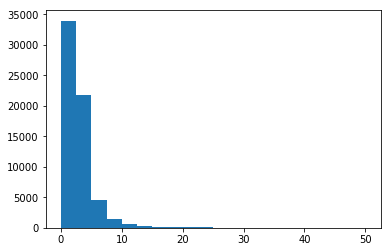

In [30]:
plt.hist([i[1] for i in img_loss], bins=20, range=(0, 50))
np.sum([i[1] > 20 for i in img_loss])

In [20]:
def draw_landmarks(image, landmarks, color=(128, 0, 128)):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, color, 1, -1)
    return image

In [21]:
scalemin = A.SmallestMaxSize(CROP_SIZE)
crop_transform = A.CenterCrop(CROP_SIZE, CROP_SIZE)

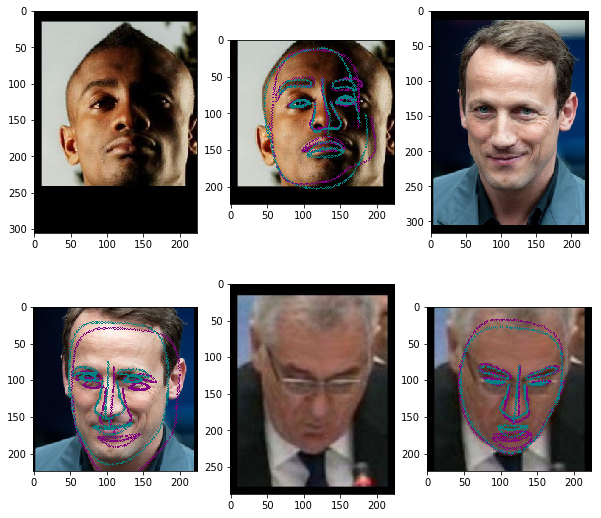

In [33]:
bad_img = img_loss[-500:]
IMG_N = 3
plt_img_names = random.sample(bad_img, IMG_N)
plt_img = [(read_img(smth[0]), *smth[1:]) for smth in plt_img_names]

plt.figure(figsize=(10, IMG_N * 3))
for i, smth in enumerate(plt_img):
    img, _, lm, pm = smth
    
    scale_img = scalemin(image=img)['image']
    plt.subplot(2, IMG_N, i * 2 + 1)
    plt.imshow(scale_img)
    
    crop_img = crop_transform(image=scale_img)['image']
    crop_img = draw_landmarks(crop_img, lm)
    crop_img = draw_landmarks(crop_img, pm, (0, 128, 128))
    
    plt.subplot(2, IMG_N, i * 2 + 2)
    plt.imshow(crop_img)


In [64]:
with open('bad_images.bd', 'w') as fout:
    fout.write('\n'.join(bad_img))